  Resolving package versions...
   Updating `C:\Users\LG\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\LG\.julia\environments\v1.4\Manifest.toml`
 [no changes]
  Resolving package versions...
  Installed Rmath ──────────────────────── v0.6.1
  Installed CompilerSupportLibraries_jll ─ v0.3.3+0
  Installed FillArrays ─────────────────── v0.9.6
  Installed StatsFuns ──────────────────── v0.9.5
  Installed OpenSpecFun_jll ────────────── v0.5.3+3
  Installed QuadGK ─────────────────────── v2.4.1
  Installed SpecialFunctions ───────────── v0.10.3
  Installed Distributions ──────────────── v0.23.12
  Installed PDMats ─────────────────────── v0.10.1
  Installed Rmath_jll ──────────────────── v0.2.2+1
   Updating `C:\Users\LG\.julia\environments\v1.4\Project.toml`
  [31c24e10] + Distributions v0.23.12
   Updating `C:\Users\LG\.julia\environments\v1.4\Manifest.toml`
  [e66e0078] + CompilerSupportLibraries_jll v0.3.3+0
  [31c24e10] + Distributions v0.23.12
  [1a297f60

delta = 117.49263188767046
delta = 90.56906482797665
delta = 70.2572714632802
delta = 56.442120146072796
delta = 45.83568828779164
delta = 37.22580149526897
delta = 30.163382779330846
delta = 24.489882784436986
delta = 20.382577158381878
delta = 16.776733374979756
delta = 13.668189969020602
delta = 11.054776075036557
delta = 8.909163722365463
delta = 7.233754754324565
delta = 6.1631557501692384
delta = 5.236100392586735
delta = 4.437945540391098
delta = 3.7541424454080357
delta = 3.170702360619714
delta = 2.6745563542012576
delta = 2.253778512319087
delta = 1.897686675699532
delta = 1.5968507286023907
delta = 1.343039124161976
delta = 1.1291289282611956
delta = 0.9489979555134767
delta = 0.7974115812588707
delta = 0.6699121524194709
delta = 0.5627155714179253
delta = 0.4726173553195281
delta = 0.3969090054514197
delta = 0.33330462389852755
delta = 0.2798771993646483
delta = 0.2350037224255459
delta = 0.19731818621801267
delta = 0.16567152055785073
delta = 0.13909755417395786
delta = 0.

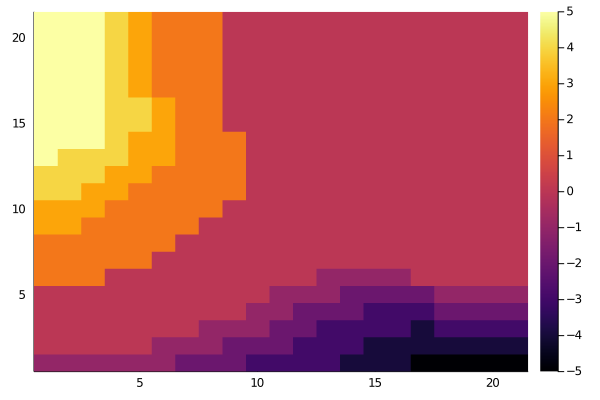

In [3]:
import Pkg; Pkg.add("Plots");Pkg.add("Distributions")
using Random, Plots, Distributions, Statistics

n = 20
k = n + 1
b = 10  # Poisson upper bound
γ = 0.9
θ = 0.1
V = zeros(Float64, k, k)
PI = zeros(Int64, k, k)

# day rental probility at location A and B for one day
A_rp =
    [(j - i, i, pdf(Poisson(3), i) * pdf(Poisson(4), j)) for i = 0:b, j = 0:b]
B_rp =
    [(j - i, i, pdf(Poisson(3), i) * pdf(Poisson(2), j)) for i = 0:b, j = 0:b]

# day rental at the end of day with a given number of cars
# return element: (car number delta, number of cars rent out, probility)
function day_rental(rp, start)
    broadcast((x, y) -> (clamp(y + x[1], 0, n), min(y, x[2]), x[3]), rp, start)
end

# value evaluation
function value_eval(A, B, orig_act)
    global k, γ, V
    v = 0.0

    for a in A, b in B
        # calculate actual action
        act = orig_act >= 0 ? min(a[1], orig_act, n - b[1]) :
            -min(b[1], abs(orig_act), n - a[1])

        # next state
        i2 = a[1] - act + 1
        j2 = b[1] + act + 1

        # extra parking cost for car number > 10
        extra = 0.0
        if a[1] - act > 10
            extra += 4
        end
        if b[1] + act > 10
            extra += 4
        end

        # free bus transport 1 car from A to B
        if act > 1
            act -= 1
        end

        v +=
            a[3] *
            b[3] *
            ((a[2] + b[2]) * 10 - abs(act) * 2 - extra + γ * V[i2, j2])
    end

    v
end

function policy_evaluation()
    global n, k, γ, θ, V, PI, A_rp, B_rp

    while true
        delta = 0.0
        for i = 1:k, j = 1:k
            A = day_rental(A_rp, i - 1)
            B = day_rental(B_rp, j - 1)

            v = value_eval(A, B, PI[i, j])

            delta = max(delta, abs(v - V[i, j]))
            V[i, j] = v
        end
        @show delta
        if delta < θ
            break
        end
    end
end

function policy_improvement()
    global n, k, γ, V, PI, A_rp, B_rp
    stable = true

    for i = 1:k, j = 1:k
        A = day_rental(A_rp, i - 1)
        B = day_rental(B_rp, j - 1)
        max_v, max_act = 0.0, 0

        for act = -5:5
            v = value_eval(A, B, act)

            if v >= max_v
                max_act = act
                max_v = v
            end
        end

        if PI[i, j] != max_act
            stable = false
        end
        PI[i, j] = max_act
    end

    stable
end

# policy iteration
policy_evaluation()
while !policy_improvement()
    policy_evaluation()
end

# draw plot for V and π
heatmap(V)
heatmap(PI)